# Goal is to answer the question: can a machine detect a person's gender based on their tweet?

Steps:
1. Get twitter data
2. Clean
3. Analyze and visualize
4. Build model
5. Test model

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import tweepy as tw
import seaborn as sns
import json
import pprint
from matplotlib import pyplot as plt

# Import libraries for WordCloud
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

import spacy
import nltk
from nltk import PorterStemmer
import textblob
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Connect to twitter API
path_auth = '/Users/allenj/Documents/Keys/auth_twitter.json'
auth = json.loads(open(path_auth).read())
pp = pprint.PrettyPrinter(indent=4)

my_consumer_key = auth['my_consumer_key']
my_consumer_secret = auth['my_consumer_secret']
my_access_token = auth['your_access_token']
my_access_token_secret = auth['my_access_token_secret']

auth = tw.OAuthHandler(my_consumer_key, my_consumer_secret)
auth.set_access_token(my_access_token, my_access_token_secret)
api = tw.API(auth)

type(api)

tweepy.api.API

# 1. Get Twitter data

In [3]:
# Upload list of desired users
# Gender 0 = male, 1 = female
users = pd.read_csv('../Data/users.csv')
users

,user,name,gender,followers_millions,activity,country
0,aaker,Jennifer Aaker,1,-,-,-
1,AdamMGrant,Adam Grant,0,-,-,-
2,Adele,Adele,1,27,Musician,United Kingdom
3,akshaykumar,Akshay Kumar,0,36,Actor,India
4,aliciakeys,Alicia Keys,1,30,Musician,United States
...,...,...,...,...,...,...
69,taylorswift13,Taylor Swift,1,86,Musician,United States
70,TheEllenShow,Ellen DeGeneres,1,80,Comedian and television hostess,United States
71,UnhealthyTruth,Robyn O'Brien,1,-,-,-
72,VeronicaMcG,Veronica McGregor,1,-,-,-


In [4]:
# Get collection of tweets from these usernames and store it into a new dataframe
list = []

for index, row in users.iterrows():
    tweets = api.user_timeline(screen_name=row['user'], count=150, include_rts=False)
    users_text = [[tweet.user.screen_name, tweet.text, row['gender']] for tweet in tweets]
    tweet_text = pd.DataFrame(data=users_text, 
                        columns=["user", "text", "gender"])
    list.append(tweet_text)

# Merge the list    
tweets = pd.concat(list) 
tweets

,user,text,gender
0,aaker,@aunder @KatieS @sarahcpr Done! Also @3GS @di...,1
1,aaker,@KatieS @sarahcpr You two both joined Humor: S...,1
2,aaker,Today was the last day of class. Feeling nosta...,1
3,aaker,@karagoldin Your masks are OUTSTANDING. we lov...,1
4,aaker,Blown away by the comic SWAT team that joined ...,1
...,...,...,...
61,wizkhalifa,Oh yea roll somethin and get tha day started.,0
62,wizkhalifa,At tha rate we’re goin a lawyer gon take joe c...,0
63,wizkhalifa,Get that @McQueenVF #McQueenTeam https://t.co/...,0
64,wizkhalifa,Contact ft @Tyga out now @Spotify \n\nhttps://...,0


In [5]:
# Count the number of datapoints per person
tweets.groupby(["user", "gender"]).size()

user            gender
AdamMGrant      0         150
Adele           1         145
AnushkaSharma   1         113
ArianaGrande    1          86
AvrilLavigne    1          93
                         ... 
staceyannchin   1         131
susanmcp1       1          50
taylorswift13   1         142
unhealthytruth  1         114
wizkhalifa      0          66
Length: 74, dtype: int64

# 2. Clean text

### Remove things

In [8]:
# Clean text by removing things
def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

#Remove @ symbol, URL links, and "&amp;"
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['text'], "@[\w]*") #removes all @
tweets

,user,text,gender,clean_text
0,aaker,@aunder @KatieS @sarahcpr Done! Also @3GS @di...,1,Done! Also #bffs
1,aaker,@KatieS @sarahcpr You two both joined Humor: S...,1,You two both joined Humor: Serious Business ...
2,aaker,Today was the last day of class. Feeling nosta...,1,Today was the last day of class. Feeling nosta...
3,aaker,@karagoldin Your masks are OUTSTANDING. we lov...,1,Your masks are OUTSTANDING. we love ours. Th...
4,aaker,Blown away by the comic SWAT team that joined ...,1,Blown away by the comic SWAT team that joined ...
...,...,...,...,...
61,wizkhalifa,Oh yea roll somethin and get tha day started.,0,Oh yea roll somethin and get tha day started.
62,wizkhalifa,At tha rate we’re goin a lawyer gon take joe c...,0,At tha rate we’re goin a lawyer gon take joe c...
63,wizkhalifa,Get that @McQueenVF #McQueenTeam https://t.co/...,0,Get that #McQueenTeam https://t.co/zjwiDopGTf
64,wizkhalifa,Contact ft @Tyga out now @Spotify \n\nhttps://...,0,Contact ft out now \n\nhttps://t.co/gVK1Z0L3...


In [10]:
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['clean_text'], "https:\/\/.*[\r\n]*")
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['clean_text'], "&amp;")
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['clean_text'], "#[\w]*") #removes all hashtags
tweets

,user,text,gender,clean_text
0,aaker,@aunder @KatieS @sarahcpr Done! Also @3GS @di...,1,Done! Also
1,aaker,@KatieS @sarahcpr You two both joined Humor: S...,1,You two both joined Humor: Serious Business ...
2,aaker,Today was the last day of class. Feeling nosta...,1,Today was the last day of class. Feeling nosta...
3,aaker,@karagoldin Your masks are OUTSTANDING. we lov...,1,Your masks are OUTSTANDING. we love ours. Th...
4,aaker,Blown away by the comic SWAT team that joined ...,1,Blown away by the comic SWAT team that joined ...
...,...,...,...,...
61,wizkhalifa,Oh yea roll somethin and get tha day started.,0,Oh yea roll somethin and get tha day started.
62,wizkhalifa,At tha rate we’re goin a lawyer gon take joe c...,0,At tha rate we’re goin a lawyer gon take joe c...
63,wizkhalifa,Get that @McQueenVF #McQueenTeam https://t.co/...,0,Get that
64,wizkhalifa,Contact ft @Tyga out now @Spotify \n\nhttps://...,0,Contact ft out now \n\n


In [7]:
# Do the same for the testing dataset
# Clean text by removing things
testset = pd.read_csv('../Data/testset.csv')
testset['clean_text'] = np.vectorize(remove_pattern)(testset['text'], "@[\w]*") #removes all @
testset['clean_text'] = np.vectorize(remove_pattern)(testset['clean_text'], "https?:\/\/.*[\r\n]*")
testset['clean_text'] = np.vectorize(remove_pattern)(testset['clean_text'], "&amp;")
testset['clean_text'] = np.vectorize(remove_pattern)(testset['clean_text'], "#[\w]*") #removes all hashtags
testset

,Unnamed: 0,user,text,gender,clean_text,length
0,0,BarackObama,My statement on the death of George Floyd: htt...,0,My statement on the death of George Floyd:,66
1,1,BarackObama,"If you believe in a more just, more generous, ...",0,"If you believe in a more just, more generous, ...",140
2,2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,"On Memorial Day, we honor those who gave all f...",140
3,3,BarackObama,And here’s more on the approach Sweden has tak...,0,And here’s more on the approach Sweden has tak...,117
4,4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea has focused on testing to guard ag...,87


### Remove punctuations

In [8]:
# Remove punctuation, numbers, and special characters
tweets['clean_text'] = tweets['clean_text'].str.replace("[^a-zA-Z#]", " ")
tweets

,user,text,gender,clean_text
0,BarackObama,"And third, an extraordinary essay by the forme...",0,And third an extraordinary essay by the forme...
1,BarackObama,"Second, a reminder of the difference politics ...",0,Second a reminder of the difference politics ...
2,BarackObama,Here’s a useful read––a reminder of the import...,0,Here s a useful read a reminder of the import...
3,BarackObama,"""Let’s do this another way. Let's stop thinkin...",0,Let s do this another way Let s stop thinkin...
4,BarackObama,Let’s get to work. https://t.co/jEczrOeFdv,0,Let s get to work
...,...,...,...,...
120,NICKIMINAJ,A small word from Jennifer Tilley as #TheBride...,1,A small word from Jennifer Tilley as Heavy ...
121,NICKIMINAJ,https://t.co/66rGZwZ2p4,1,
122,NICKIMINAJ,Stop playin wit me like 4 real,1,Stop playin wit me like real
123,NICKIMINAJ,😂🤣😩 https://t.co/fZriKEQqMf,1,


In [9]:
# Do the same for the testing dataset
# Remove punctuation, numbers, and special characters
testset['clean_text'] = testset['clean_text'].str.replace("[^a-zA-Z#]", " ")
testset

,Unnamed: 0,user,text,gender,clean_text,length
0,0,BarackObama,My statement on the death of George Floyd: htt...,0,My statement on the death of George Floyd,66
1,1,BarackObama,"If you believe in a more just, more generous, ...",0,If you believe in a more just more generous ...,140
2,2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,On Memorial Day we honor those who gave all f...,140
3,3,BarackObama,And here’s more on the approach Sweden has tak...,0,And here s more on the approach Sweden has tak...,117
4,4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea has focused on testing to guard ag...,87


### Remove stop words

In [10]:
# Remove short words less than 3
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
tweets.head(10)

,user,text,gender,clean_text
0,BarackObama,"And third, an extraordinary essay by the forme...",0,third extraordinary essay former Chairman Join...
1,BarackObama,"Second, a reminder of the difference politics ...",0,Second reminder difference politics voting mak...
2,BarackObama,Here’s a useful read––a reminder of the import...,0,Here useful read reminder importance escalatio...
3,BarackObama,"""Let’s do this another way. Let's stop thinkin...",0,this another stop thinking voice matter vote j...
4,BarackObama,Let’s get to work. https://t.co/jEczrOeFdv,0,work
5,BarackObama,I know the past few months have been hard and ...,0,know past months have been hard dispiriting wa...
6,BarackObama,"If you want to take concrete action, but you’r...",0,want take concrete action sure created site co...
7,BarackObama,5. The more specific we can make demands for c...,0,more specific make demands criminal justice po...
8,BarackObama,"4. So if we want to bring about real change, t...",0,want bring about real change choice between pr...
9,BarackObama,"3. To do that, we have to know which levels of...",0,that have know which levels government have bi...


In [11]:
# Do the same for the testing dataset
# Remove short words less than 2
testset['clean_text'] = testset['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
testset.head(10)

,Unnamed: 0,user,text,gender,clean_text,length
0,0,BarackObama,My statement on the death of George Floyd: htt...,0,statement death George Floyd,66
1,1,BarackObama,"If you believe in a more just, more generous, ...",0,believe more just more generous more democrati...,140
2,2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,Memorial honor those gave That takes different...,140
3,3,BarackObama,And here’s more on the approach Sweden has tak...,0,here more approach Sweden taken which differs ...,117
4,4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea focused testing guard against outb...,87


### Create new column to count length of clean text

In [107]:
# Count length of characters
tweets['length'] = tweets['clean_text'].apply(len)
tweets

,user,text,gender,clean_text,length
0,BarackObama,"And third, an extraordinary essay by the forme...",0,third extraordinary essay former Chairman Join...,73
1,BarackObama,"Second, a reminder of the difference politics ...",0,Second reminder difference politics voting mak...,79
2,BarackObama,Here’s a useful read––a reminder of the import...,0,Here useful read reminder importance escalatio...,89
3,BarackObama,"""Let’s do this another way. Let's stop thinkin...",0,this another stop thinking voice matter vote j...,65
4,BarackObama,Let’s get to work. https://t.co/jEczrOeFdv,0,work,4
...,...,...,...,...,...
120,NICKIMINAJ,A small word from Jennifer Tilley as #TheBride...,1,small word from Jennifer Tilley Heavy Sleeze,44
121,NICKIMINAJ,https://t.co/66rGZwZ2p4,1,,0
122,NICKIMINAJ,Stop playin wit me like 4 real,1,Stop playin like real,21
123,NICKIMINAJ,😂🤣😩 https://t.co/fZriKEQqMf,1,,0


In [100]:
# Do the same for the testing dataset
# Count length
testset['length'] = testset['clean_text'].apply(len)
testset

,Unnamed: 0,user,text,gender,clean_text,length
0,0,BarackObama,My statement on the death of George Floyd: htt...,0,statement death George Floyd,28
1,1,BarackObama,"If you believe in a more just, more generous, ...",0,believe more just more generous more democrati...,71
2,2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,Memorial honor those gave That takes different...,78
3,3,BarackObama,And here’s more on the approach Sweden has tak...,0,here more approach Sweden taken which differs ...,65
4,4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea focused testing guard against outb...,51


### Remove rows in training data that have less than desired text length

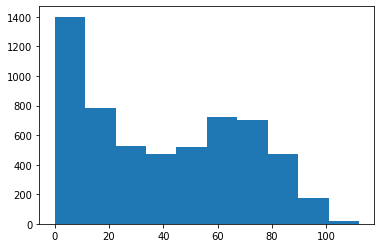

In [104]:
plt.hist(tweets['length'])
plt.show()

In [109]:
tweets['length'].describe()

count    5794.000000
mean       39.769071
std        29.638238
min         0.000000
25%        12.000000
50%        37.000000
75%        66.000000
max       112.000000
Name: length, dtype: float64

In [130]:
# Remove rows where length <= 40
tweets = tweets[tweets.length > 40]
tweets

,user,text,gender,clean_text,length
0,BarackObama,"And third, an extraordinary essay by the forme...",0,third extraordinary essay former Chairman Join...,73
1,BarackObama,"Second, a reminder of the difference politics ...",0,Second reminder difference politics voting mak...,79
2,BarackObama,Here’s a useful read––a reminder of the import...,0,Here useful read reminder importance escalatio...,89
3,BarackObama,"""Let’s do this another way. Let's stop thinkin...",0,this another stop thinking voice matter vote j...,65
5,BarackObama,I know the past few months have been hard and ...,0,know past months have been hard dispiriting wa...,85
...,...,...,...,...,...
115,NICKIMINAJ,"Y’all, should I do #QueenRadio on... FRIDAY or...",1,should FRIDAY chiiiiileeeee needz into thangzz...,52
116,NICKIMINAJ,Thank you baby. This was so sweet &amp; genuin...,1,Thank baby This sweet genuine guys help much m...,64
118,NICKIMINAJ,Miserable ppl will always find something negat...,1,Miserable will always find something negative ...,96
120,NICKIMINAJ,A small word from Jennifer Tilley as #TheBride...,1,small word from Jennifer Tilley Heavy Sleeze,44


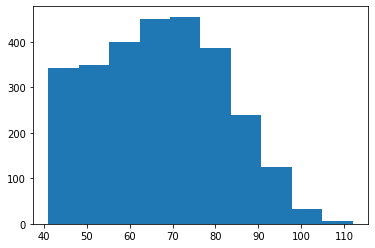

In [131]:
plt.hist(tweets['length'])
plt.show()

### Tokenize, stem, and stich back

In [ ]:
# # Tokenization
# tokenized_tweet = tweets['clean_text'].apply(lambda x: x.split())
# tokenized_tweet.head()

In [ ]:
# # Do the same for the testing dataset
# # Tokenization
# tokenized_testset = testset['clean_text'].apply(lambda x: x.split())
# tokenized_testset.head()

In [ ]:
# # Stemming
# ps = PorterStemmer()
# tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])
# tokenized_tweet.head()

In [ ]:
# # Do the same for the testing dataset
# # Stemming
# ps = PorterStemmer()
# tokenized_testset = tokenized_testset.apply(lambda x: [ps.stem(i) for i in x])
# tokenized_testset.head()

In [ ]:
# # Stich tokens back together
# for i in range(len(tokenized_tweet)):
#     tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
          
# testset['clean_text'] = tokenized_tweet
# testset['clean_text']

In [ ]:
# # Stich tokens back together
# for i in range(len(tokenized_tweet)):
#     tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
          
# testset['clean_text'] = tokenized_tweet
# testset['clean_text']

# 4. Model Selectioin and Machine Learning

### Bag of Words

In [132]:
# Bag-of-Words features
bow_vectorizer = CountVectorizer(stop_words='english')

# Bag-of-Words feature matrix
bow = bow_vectorizer.fit_transform(tweets['clean_text'])
df_bow = pd.DataFrame(bow.todense(), columns=bow_vectorizer.get_feature_names())
df_bow

,aadar,aaiye,aane,aankhon,aapka,aapke,aapko,aata,aate,aati,...,zingers,zion,zohaib,zones,zoom,zootopia,zordaar,zubaan,zurich,zyaada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2779,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2780,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
# Do the same for test dataset
# Bag-of-Words feature matrix
bow = bow_vectorizer.transform(testset['clean_text'])
df_bow_test = pd.DataFrame(bow.todense(), columns=bow_vectorizer.get_feature_names())
df_bow_test

,aadar,aaiye,aane,aankhon,aapka,aapke,aapko,aata,aate,aati,...,zingers,zion,zohaib,zones,zoom,zootopia,zordaar,zubaan,zurich,zyaada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Use Bag of Words to Build Model

In [191]:
# Splitting the data into training and validation set
X = df_bow
y = tweets['gender']

# Use Bag-of-Words Features
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X, y, test_size=0.2)

### Use Logistic Regression

In [167]:
# Fitting on Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train_bow, y_train_bow)

LogisticRegression()

In [168]:
# The first part of the list is predicting probabilities for gender:0 (male)
# The second part of the list is predicting probabilities for gender:1 (female)
prediction_bow = logreg.predict_proba(X_test_bow)
prediction_bow

array([[0.35846407, 0.64153593],
       [0.46872355, 0.53127645],
       [0.5954562 , 0.4045438 ],
       ...,
       [0.85877901, 0.14122099],
       [0.63142813, 0.36857187],
       [0.63101111, 0.36898889]])

In [169]:
# Calculating the F1 score
# If prediction is greater than or equal to 0.3 than 1, else 0
# Where 0 is for male tweets and 1 is for female tweets
prediction_int = prediction_bow[:,1]>=0.5

prediction_int = prediction_int.astype(np.int)
prediction_int

# Calculating f1 score
log_bow = f1_score(y_test_bow, prediction_int)

log_bow

0.6543438077634011

### Predict with separate test dataset

In [170]:
# Check if there is a fit model
logreg.intercept_, logreg.coef_

(array([-0.01025301]),
 array([[-0.07471349,  0.        , -0.04655919, ..., -0.13605041,
          0.24267671, -0.13605041]]))

In [171]:
z = df_bow_test
pred = logreg.predict_proba(z)
pred

array([[0.29099551, 0.70900449],
       [0.17443132, 0.82556868],
       [0.73187637, 0.26812363],
       [0.77198739, 0.22801261],
       [0.80648108, 0.19351892]])

In [176]:
pred2 = logreg.predict(z)
pred2

array([1, 1, 0, 0, 0])

In [177]:
df = pd.DataFrame(data=pred)
df

,0,1
0,0.290996,0.709004
1,0.174431,0.825569
2,0.731876,0.268124
3,0.771987,0.228013
4,0.806481,0.193519


In [178]:
pred2 = pd.DataFrame(data=pred2, columns=['predicted_gender'])
pred2

,predicted_gender
0,1
1,1
2,0
3,0
4,0


In [179]:
testset.join(pred2)

,Unnamed: 0,user,text,gender,clean_text,length,predicted_gender
0,0,BarackObama,My statement on the death of George Floyd: htt...,0,statement death George Floyd,28,1
1,1,BarackObama,"If you believe in a more just, more generous, ...",0,believe more just more generous more democrati...,71,1
2,2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,Memorial honor those gave That takes different...,78,0
3,3,BarackObama,And here’s more on the approach Sweden has tak...,0,here more approach Sweden taken which differs ...,65,0
4,4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea focused testing guard against outb...,51,0


### Use TF-IDF

In [198]:
# TF-IDF features (Term Frequency-Inverse Document Frequency)
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(tweets['clean_text'])
df_tfidf = pd.DataFrame(tfidf_matrix.todense(), columns=tfidf.get_feature_names())
df_tfidf

,aadar,aaiye,aane,aankhon,aapka,aapke,aapko,aata,aate,aati,...,zingers,zion,zohaib,zones,zoom,zootopia,zordaar,zubaan,zurich,zyaada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
# Do the same for the test dataset
# TF-IDF features (Term Frequency-Inverse Document Frequency)
tfidf_matrix=tfidf.transform(testset['clean_text'])
df_tfidf_test = pd.DataFrame(tfidf_matrix.todense(), columns=tfidf.get_feature_names())
df_tfidf_test

,aadar,aaiye,aane,aankhon,aapka,aapke,aapko,aata,aate,aati,...,zingers,zion,zohaib,zones,zoom,zootopia,zordaar,zubaan,zurich,zyaada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Use TF-IDF to Build Model

In [210]:
# Splitting the data into training and validation set
X = df_tfidf
y = tweets['gender']

# Use Bag-of-Words Features
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.2)

In [211]:
# Using TF-IDF Features
logreg.fit(X_train_tfidf, y_train_tfidf)

LogisticRegression()

In [212]:
prediction_tfidf = logreg.predict_proba(X_test_tfidf)
prediction_tfidf

array([[0.56288916, 0.43711084],
       [0.50174778, 0.49825222],
       [0.52570267, 0.47429733],
       ...,
       [0.41442657, 0.58557343],
       [0.53843801, 0.46156199],
       [0.56011837, 0.43988163]])

In [221]:
# Calculating the F1 score
prediction_int = prediction_tfidf[:,1]>=0.5
prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_tfidf = f1_score(y_test_tfidf, prediction_int)
log_tfidf

0.685288640595903

### Use Decision Tree

In [214]:
# Decision Tree
dtc = DecisionTreeClassifier(criterion='entropy', random_state=1)

In [237]:
# Using Bag of Words as features
dtc.fit(X_train_bow, y_train_bow)
dtc_bow = dtc.predict_proba(X_test_bow)
dtc_bow

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [238]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
dtc_bow = dtc_bow[:,1]>=0.5

# converting the results to integer type
dtc_int_bow=dtc_bow.astype(np.int)

# calculating f1 score
dtc_score_bow=f1_score(y_test_bow, dtc_int_bow)

dtc_score_bow

0.5844402277039848

In [227]:
# Using TF-IDF
dtc.fit(x_train_tfidf,y_train_tfidf)

NameError: name 'dct' is not defined

In [235]:
dtc_tfidf = dtc.predict_proba(X_test_tfidf)

dtc_tfidf

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [236]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
dtc_tfidf=dtc_tfidf[:,1]>=0.3

# converting the results to integer type
dtc_int_tfidf=dtc_tfidf.astype(np.int)

# calculating f1 score
dtc_score_tfidf=f1_score(y_test_tfidf,dtc_int_tfidf)

dtc_score_tfidf

0.1288135593220339

In [ ]:
# Model Comparison
Algo=['LogisticRegression(Bag-of-Words)','DecisionTree(Bag-of-Words)','LogisticRegression(TF-IDF)','DecisionTree(TF-IDF)']


In [ ]:
score = [log_bow,dct_score_bow,log_tfidf,dct_score_tfidf]

compare=pd.DataFrame({'Model':Algo,'F1_Score':score},index=[i for i in range(1,5)])
compare.T


In [ ]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1_Score',data=compare)

plt.title('Model Vs Score')
plt.xlabel('MODEL')
plt.ylabel('SCORE')

plt.show()

# Test With Real Text

In [ ]:
# Check if there is a fit model

In [ ]:
Log_Reg.intercept_, Log_Reg.coef_

In [ ]:
test_text = pd.read_csv('../Data/tweetstest.csv')
test_text

In [ ]:
bow = bow_vectorizer.transform(test_text['clean_text']) #use .transform() not .fit_transform()
df_bow = pd.DataFrame(bow.todense())
df_bow

In [ ]:
prediction_bow = Log_Reg.predict_proba(X)
prediction_bow

In [ ]:
test_text = "this is a test tweet to predict my gender baby boo"

# Bag-of-Words feature matrix
bow = bow_vectorizer.fit_transform('test_text')
df_bow = pd.DataFrame(bow.todense())
df_bow

In [ ]:
text = "I am so angry"
textBlob = TextBlob(text)
print(f"{textBlob.sentiment}")

# ###### 

#### 